<div align="center">
<h1>Stage 8: Model Evaluation</a></h1>
by Hongnan Gao
<br>
</div>

## Dependencies and Configuration

In [1]:
%%capture
!pip install -q wandb
# !pip install -q shap
!pip install -q mlxtend==0.19.0
!pip install -q statsmodels==0.13.1
# !pip install gcloud == 0.18.3

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import copy
import csv
import logging
import os
import random
from dataclasses import asdict, dataclass, field
from functools import wraps
from pathlib import Path
from time import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
from mlxtend.evaluate import bias_variance_decomp, paired_ttest_5x2cv
from scipy import stats
from sklearn import (base, decomposition, dummy, ensemble, feature_selection,
                     linear_model, metrics, model_selection, neighbors,
                     pipeline, preprocessing, svm, tree)
from statsmodels.regression.linear_model import OLS

## Utils and Configurations

We need import `ReduceVIF` if not we cannot call our model.

In [5]:
@dataclass
class config:
    raw_data: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/raw/data.csv"
    processed_data: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/processed/processed.csv"
    df_folds: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/processed/df_folds.csv"
    train_size: float = 0.9
    seed: int = 1992
    num_folds: int = 5
    cv_schema: str = "StratifiedKFold"
    classification_type: str = "binary"

    target_col: List[str] = field(default_factory=lambda: ["diagnosis"])
    unwanted_cols: List[str] = field(
        default_factory=lambda: ["id", "Unnamed: 32"]
    )

    # Plotting
    colors: List[str] = field(
        default_factory=lambda: ["#fe4a49", "#2ab7ca", "#fed766", "#59981A"]
    )
    cmap_reversed = plt.cm.get_cmap("mako_r")

    def to_dict(self) -> Dict[str, Any]:
        """Convert the config object to a dictionary.

        Returns:
            Dict: The config object as a dictionary.
        """

        return asdict(self)


#     spot_checking_boxplot = "../data/images/spot_checking_boxplot.png"
#     oof_confusion_matrix = "../data/images/oof_confusion_matrix.png"
#     final_train_confusion_matrix = "../data/images/final_train_confusion_matrix.png"
#     precision_recall_threshold_plot = "../data/images/precision_recall_threshold_plot.png"
#     roc_plot = "../data/images/roc_plot.png"
#     feature_importance = "../data/images/feature_importance.png"

In [6]:
def set_seeds(seed: int = 1234) -> None:
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    
def init_logger(log_file: str = "info.log"):
    """
    Initialize logger.
    """
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(logging.Formatter("%(asctime)s - %(message)s", datefmt= "%Y-%m-%d,%H:%M:%S"))
    file_handler = logging.FileHandler(filename=log_file)
    file_handler.setFormatter(logging.Formatter("%(asctime)s - %(message)s",  datefmt= "%Y-%m-%d,%H:%M:%S"))
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    return logger

In [7]:
# Utils functions that we need

def variance_inflation_factor(exog, idx_kept, vif_idx):
    """Compute VIF for one feature.
    
    Args:
        exog (np.ndarray): Observations
        idx_kept (List[int]): Indices of features to consider
        vif_idx (int): Index of feature for which to compute VIF
    
    Returns:
        float: VIF for the selected feature
    """
    exog = np.asarray(exog)
    
    x_i = exog[:, vif_idx]
    mask = [col for col in idx_kept if col != vif_idx]
    x_noti = exog[:, mask]
    
    r_squared_i = OLS(x_i, x_noti).fit().rsquared
    vif = 1. / (1. - r_squared_i)
    
    return vif

class ReduceVIF(base.BaseEstimator, base.TransformerMixin):
    """The base of the class structure is implemented in https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class;
    I heavily modified the class such that it can take in numpy arrays and correctly implemented the fit and transform method.
    """

    def __init__(self, thresh=10, max_drop=20):
        self.thresh = thresh
        self.max_drop = max_drop
        self.column_indices_kept_ = []
        self.feature_names_kept_ = None

    def reset(self):
        """Resets the state of predictor columns after each fold."""

        self.column_indices_kept_ = []
        self.feature_names_kept_ = None

    def fit(self, X, y=None):
        """Fits the Recursive VIF on the training folds and save the selected feature names in self.feature_names

        Args:
            X ([type]): [description]
            y ([type], optional): [description]. Defaults to None.

        Returns:
            [type]: [description]
        """
        
        self.column_indices_kept_, self.feature_names_kept_ = self.calculate_vif(X)     
        
        return self

    def transform(self, X, y=None):
        """Transforms the Validation Set according to the selected feature names.

        Args:
            X ([type]): [description]
            y ([type], optional): [description]. Defaults to None.

        Returns:
            [type]: [description]
        """

        return X[:, self.column_indices_kept_]

    def calculate_vif(self, X: Union[np.ndarray, pd.DataFrame]):
        """Implements a VIF function that recursively eliminates features.

        Args:
            X (Union[np.ndarray, pd.DataFrame]): [description]

        Returns:
            [type]: [description]
        """
        feature_names = None
        column_indices_kept = list(range(X.shape[1]))
        
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns

        dropped = True
        count = 0
        
        while dropped and count <= self.max_drop:
            dropped = False
            
            max_vif, max_vif_col = None, None
            
            for col in column_indices_kept:
                
                vif = variance_inflation_factor(X, column_indices_kept, col)
                
                if max_vif is None or vif > max_vif:
                    max_vif = vif
                    max_vif_col = col
            
            if max_vif > self.thresh:
                # print(f"Dropping {max_vif_col} with vif={max_vif}")
                column_indices_kept.remove(max_vif_col)
                
                if feature_names is not None:
                    feature_names.pop(max_vif_col)
                    
                dropped = True
                count += 1
                
        return column_indices_kept, feature_names


def prepare_y(y: np.ndarray) -> np.ndarray:
    """Prepare the target variable for the model.

    If Binary Classification, we need to ravel the array to 1d.

    Args:
        y (np.ndarray): Target variable.

    Returns:
        np.ndarray: Transformed Target variable.
    """
    return y.ravel() if config.classification_type == "binary" else y

In [8]:
config = config()
logger = init_logger()

In [9]:
# set seeding for reproducibility
_ = set_seeds(seed = config.seed)

# read data
df_folds = pd.read_csv(config.df_folds)

In [10]:
# Assign predictors and target accordingly
predictor_cols = df_folds.columns.to_list()[:-2]
target_col = config.target_col

## Resume Run and Load Weights

Here we resume `wandb` using its `run_id` and then load the model's weights.

In [11]:
# Resume run by getting run_id
# TODO: return id as an artifact so we can get it easily.
run = wandb.init(project="bcw", name="classification", resume=True, id = '3qh37hoo')

wandb: Currently logged in as: reighns (use `wandb login --relogin` to force relogin)


In [12]:
logistic_path = "LogisticRegression_grid.joblib"
dt_path = "DecisionTreeClassifier_grid.joblib"
gdb_path = "GradientBoostingClassifier_grid.joblib" 
logistic_best_weight = wandb.restore(logistic_path)
logistic_best_model = load(logistic_best_weight.name)

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


## Interpretation of Results

### Interpretation of Coefficients

As shown in the figure below, all else being equal, for every square unit increase in mean cell area, the odds of the tumor being malignant increases by a factor of $e^{1.43} = 4.19$. The variation (standard error) of the characteristics of cells also are deemed important by the model, for example, area se played an important role in determining whether a cell is malignant; intuitively, if some cells are noticably larger than the rest, then it is also a good indicator of malignancy.

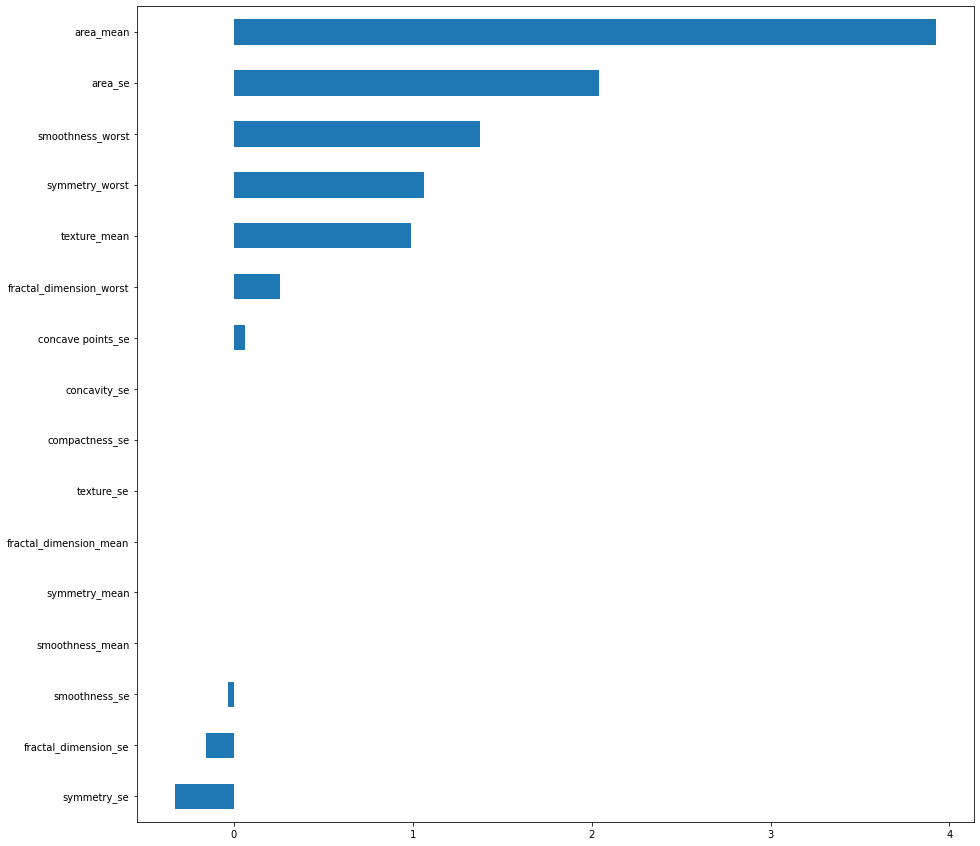

In [16]:
selected_features_by_vif_index = logistic_best_model.best_estimator_['remove_multicollinearity'].column_indices_kept_ 
selected_feature_names = np.asarray(predictor_cols)[selected_features_by_vif_index]

selected_features_coefficients = logistic_best_model.best_estimator_['model'].coef_.flatten()

# assertion
#assert grid.best_estimator_['remove_multicollinearity'].feature_names_ == retrain_pipeline['remove_multicollinearity'].feature_names_

fig, ax = plt.subplots(figsize=(15, 15))
# .abs()
_ = pd.Series(selected_features_coefficients, index=selected_feature_names).sort_values().plot(ax=ax, kind='barh')
# fig.savefig(config.feature_importance, format="png", dpi=300)

### Interpretation of Metric Scores on Train Set

We are also interested in choosing an optimal threshold for the model such that it gives the lowest recall, or False Negatives. We note that the default threshold when calling `predict()` from a model is $0.5$. In this section, we will explore one way to get the best tradeoff we can when choosing a high recall, while maintaining a reasonable score for precision.

In [17]:
def evaluate_train_test_set(
    estimator: Callable, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.DataFrame, np.ndarray]
) -> Dict[str, Union[float, np.ndarray]]:
    """This function takes in X and y and returns a dictionary of scores.

    Args:
        estimator (Callable): [description]
        X (Union[pd.DataFrame, np.ndarray]): [description]
        y (Union[pd.DataFrame, np.ndarray]): [description]

    Returns:
        Dict[str, Union[float, np.ndarray]]: [description]
    """

    test_results = {}

    y_pred = estimator.predict(X)
    # This is the probability array of class 1 (malignant)
    y_prob = estimator.predict_proba(X)[:, 1]

    test_brier = metrics.brier_score_loss(y, y_prob)
    test_roc = metrics.roc_auc_score(y, y_prob)

    test_results["brier"] = test_brier
    test_results["roc"] = test_roc
    test_results["y"] = np.asarray(y).flatten()
    test_results["y_pred"] = y_pred.flatten()
    test_results["y_prob"] = y_prob.flatten()

    return test_results


In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.89 
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.savefig(config.precision_recall_threshold_plot, format="png", dpi=300)
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    plt.savefig(config.roc_plot, format="png", dpi=300)
    
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    and courtesy of https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    return [1 if y >= t else 0 for y in y_scores]

The plots below show the tradeoffs between precision and recall, recall and false positive rate. The confusion matrix on the train set tells us that there is still more false negatives than false positives. We can choose a particular threshold in order to minimize false negatives, at some expense of false positive.

In [21]:
X_train, y_train = df_folds[predictor_cols].values, df_folds[target_col].values
y_train = prepare_y(y_train)

In [22]:
train_results = evaluate_train_test_set(logistic_best_model, X_train, y_train)

In [23]:
def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: str,
    labels: List[str],
    tick_labels: List[str],
) -> None:
    """Plots a Binary Confusion Matrix.

    Args:
        y_true (np.ndarray): the actual labels.
        y_pred (np.ndarray): the predicted labels.
        title (str): the title of the plot.
        tick_labels (List[str]): The labels for the ticks.
    """

    # Unravel into tn, fp, fn and tp
    tn, fp, fn, tp = metrics.confusion_matrix(
        y_true, y_pred, labels=labels
    ).ravel()

    # reshape into tp, fp, fn, tn - this is personal preference
    reshaped_cm = np.asarray([[tp, fp], [fn, tn]])

    # flatten this 2d array
    cm_flattened = reshaped_cm.flatten()

    labels = [
        "True Positive",
        "False Positive",
        "False Negative",
        "True Negative",
    ]
    annot = (
        np.asarray(
            [
                f"{label}\n{cm_count}"
                for label, cm_count in zip(labels, cm_flattened)
            ]
        )
    ).reshape(2, 2)

    ax = plt.subplot()
    heatmap = sns.heatmap(
        reshaped_cm,
        annot=annot,
        fmt="",
        cmap="Greens",
        ax=ax,
        xticklabels=tick_labels,
        yticklabels=tick_labels,
    )
    ax.set_title(title)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    plt.show()

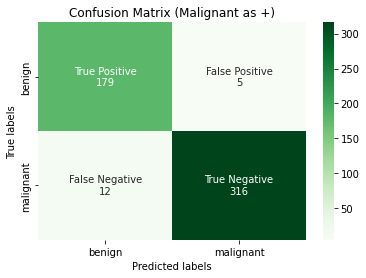

In [25]:
# CM
y_true, y_pred = train_results['y'], train_results['y_pred']

plot_confusion_matrix(
    y_true,
    y_pred,
    title="Confusion Matrix (Malignant as +)",
    labels=[0, 1],
    tick_labels=["benign", "malignant"],
)


AttributeError: ignored

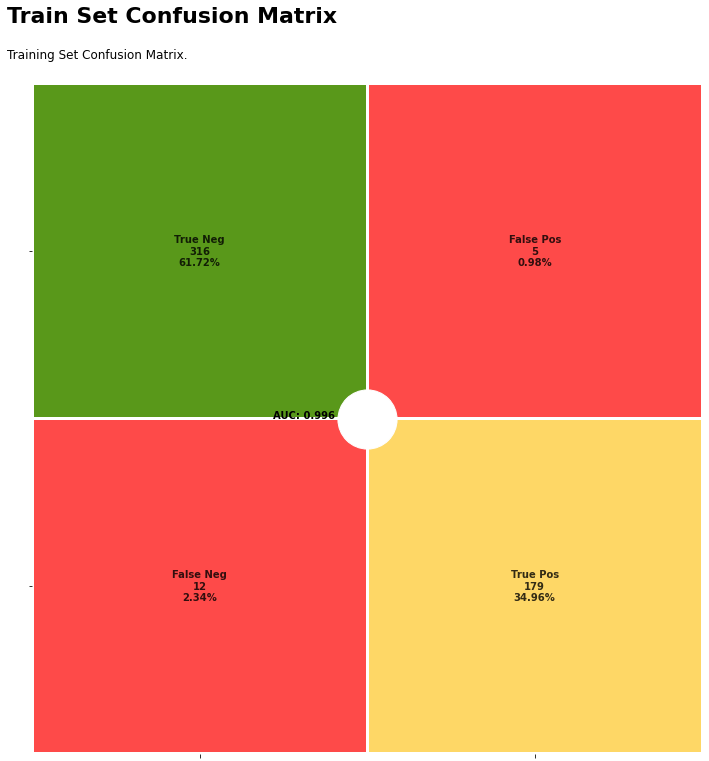

In [26]:
# fig, ax = plt.subplots(figsize=(10, 10))

# # CM
# cm_train = metrics.confusion_matrix(train_results['y'], train_results['y_pred'])

# #### scores
# auc = metrics.roc_auc_score(train_results['y'], train_results['y_prob'])

# #### annotations
# labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
# counts = ["{0:0.0f}".format(value) for value in cm_train.flatten()]
# percentages = ["{0:.2%}".format(value) for value in cm_train.flatten() / np.sum(cm_train)]

# #### final annotations
# label = (
#     np.array([f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)])
# ).reshape(2, 2)

# # heatmap
# sns.heatmap(
#     data=cm_train,
#     vmin=0,
#     vmax=330,
#     cmap=["#fe4a49", "#2ab7ca", "#fed766", "#59981A"],
#     linewidth=2,
#     linecolor="white",
#     square=True,
#     ax=ax,
#     annot=label,
#     fmt="",
#     cbar=False,
#     annot_kws={"size": 10, "color": "black", "weight": "bold", "alpha": 0.8},
#     alpha=1,
# )



# ax.scatter(1, 1, s=3500, c="white")
# ax.text(
#     0.72,
#     1.0,
#     "AUC: {}".format(round(auc, 3)),
#     {"size": 10, "color": "black", "weight": "bold"},
# )

# ## ticks and labels
# ax.set_xticklabels("")
# ax.set_yticklabels("")


# ## titles and text
# fig.text(0, 1.05, "Train Set Confusion Matrix", {"size": 22, "weight": "bold"}, alpha=1)
# fig.text(
#     0,
#     1,
#     """Training Set Confusion Matrix.""",
#     {"size": 12, "weight": "normal"},
#     alpha=0.98,
# )


# fig.tight_layout(pad=2.5, w_pad=2.5, h_pad=2.5)
# # fig.savefig(config.final_train_confusion_matrix, format='png', dpi=300)

In [27]:
# generate the precision recall curve
precision, recall, pr_thresholds = metrics.precision_recall_curve(train_results['y'], train_results['y_prob'])
fpr, tpr, roc_thresholds = metrics.roc_curve(train_results['y'], train_results['y_prob'], pos_label=1)

AttributeError: ignored

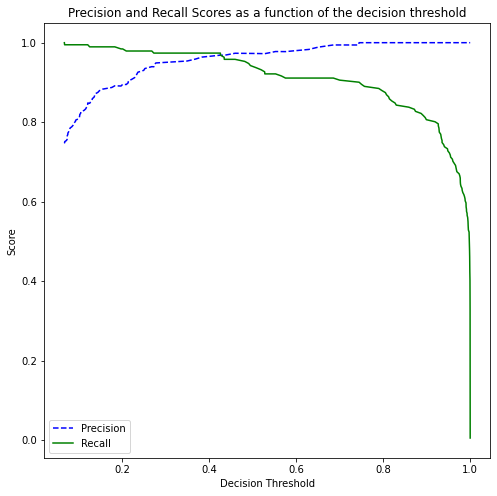

In [28]:
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(precision, recall, pr_thresholds)

Based on the tradeoff plot above, a good threshold can be set at $t = 0.35$, let us see how it performs with this threshold.

In [29]:
y_pred_adj = adjusted_classes(train_results["y_prob"], t=0.35)

print(
    pd.DataFrame(
        metrics.confusion_matrix(train_results["y"], y_pred_adj),
        columns=["pred_neg", "pred_pos"],
        index=["neg", "pos"],
    )
)

     pred_neg  pred_pos
neg       313         8
pos         5       186


In [30]:
print(metrics.classification_report(y_true=train_results["y"], y_pred=y_pred_adj))
train_brier = train_results['brier']
print(f"train brier: {train_brier}")

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       321
           1       0.96      0.97      0.97       191

    accuracy                           0.97       512
   macro avg       0.97      0.97      0.97       512
weighted avg       0.97      0.97      0.97       512

train brier: 0.022402196649862854


The False Negatives reduced from 15 to 9, at the expense of increase False Positives from 6 to 14. We should take comfort that less patients are falsely classified as benign when in fact they need treatment. This is a tradeoff that we have to choose. The ROC curve below also paints a similar story, in order for you to have high recall, one must accept that there will more False Positives.

AttributeError: ignored

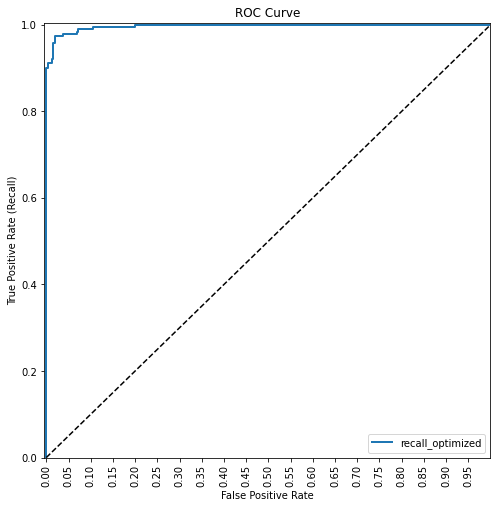

In [31]:
plot_roc_curve(fpr, tpr, 'recall_optimized')

# Evaluation on Test Set

Ultimately, we are interested in finding the estimate of the generalization error of the model, and thus it is time for us to evaluate our model's performance on the "unseen" test set $X_{\text{test}}$ to get a good gauge on how well the model generalizes to unseen data. Take note that now everything has settled, we will use the exact hyperparameters to predict on test set, with the pre-defined threshold of 0.35.

In [32]:
test_results = evaluate_train_test_set(grid, X_test, y_test)
y_test_pred_adj = adjusted_classes(test_results['y_prob'], t=0.35)

print(pd.DataFrame(metrics.confusion_matrix(test_results['y'], y_test_pred_adj),
                   columns=['pred_neg', 'pred_pos'], 
                   index=['neg', 'pos']))

NameError: ignored

In [33]:
test_roc = test_results['roc']
test_brier = test_results['brier']
print(test_roc)
print(test_brier)
print(metrics.classification_report(y_true=test_results["y"], y_pred=y_test_pred_adj))

NameError: ignored

Using the same threshold we used on training set, we see that the False Negative is quite low. The overall ROC score is 0.9828, and the corresponding Brier Score is 0.04136, both seem reasonably well performing.

# Benefit Structure

Refer to health insurance project!

https://ghnreigns.github.io/reighns-ml-website/metrics/classification_metrics/confusion_matrix/#benefit-structure

In [ ]:
# threshold_list : List[float] = [0.01, 0.1, 0.2, 0.5]
# benefit_dict : Dict[str, int] = {"old_structure": {"tp":10, "fn":-10, "fp": -2, "tp+fp":-1},
#                                  "new_structure": {"tp":100, "fn": -100, "fp": -2, "tn+fp":-1}}

# columns = ["threshold", "tp", "fn", "fp", "tn", "benefit_cost_old", "benefit_cost_new"]
# benefit_cost_list = []

# for t in threshold_list:
#     y_pred_adj = adjusted_classes(y_test_dt_prob, t=t)
#     cm = metrics.confusion_matrix(y_true=y_test_gt, y_pred = y_pred_adj)
#     tn, fp, fn, tp = metrics.confusion_matrix(y_true=y_test_gt, y_pred = y_pred_adj).ravel()
    
#     # this one check if it is correct formula
#     benefit_cost_old = tp*10 - fn*10 - fp*2 - (tp+fp)*1
#     benefit_cost_new = tp*100 - fn*100 - fp*2 - (tp+fp)*1
    
#     benefit_cost_list.append([t, tn, fn, fp, tn, benefit_cost_old, benefit_cost_new])
    

In [ ]:
benefit_df = pd.DataFrame(benefit_cost_list,
                   columns=columns)
benefit_df

# Bias-Variance Tradeoff

In [ ]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        grid.best_estimator_['model'], X_train.values, y_train.values, X_test.values, y_test.values, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

We use the `mlxtend` library to estimate the Bias-Variance Tradeoff in our Logistic Regression model. The core idea behind this function is to use bagging and repeatedly sample from our training set so as to simulate that we are actually drawing samples from the "true" population over a distribution $\mathcal{P}$. 

---

As expected, Logistic Regression being a linear model, its simplicity contributes to its high bias and low variance. 